In [1]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
imageSize = 128
batchSize = 1
lrD = 2e-4
lrG = 2e-4
ngf=64
ndf=64

In [3]:
import glob
from PIL import Image
from random import shuffle
import numpy as np

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_img(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize((imageSize, imageSize), Image.BILINEAR)
    arr = np.array(im)/255*2-1
    return arr

dataset = 'horse2zebra'
train_A = load_data('../data/{}/trainA/*.jpg'.format(dataset))
train_B = load_data('../data/{}/trainB/*.jpg'.format(dataset))
test_A = load_data('../data/{}/testA/*.jpg'.format(dataset))
test_B = load_data('../data/{}/testB/*.jpg'.format(dataset))

In [4]:
from IPython.display import display
def showX(images, rows=1):
    _, w, h, c = images.shape
    arr = ((images+1)*255/2).clip(0, 255).astype('uint8')
    arr = arr.reshape(rows, -1, w, h, c).swapaxes(1, 2).reshape(rows*w, -1, c)
    display(Image.fromarray(arr))

In [5]:
def minibatch(dataset, batchSize):
    epoch = 0
    i = 0
    length = len(dataset)
    tempSize = None
    while True:
        if i + batchSize > length:
            shuffle(dataset)
            epoch += 1
            i = 0
        dataBatch = []
        for j in range(i, i+batchSize):
            dataBatch.append(read_img(dataset[j]))
        i += batchSize
        tempSize = yield epoch, np.float32(dataBatch)
        
def minibatchAB(datasetA, datasetB, batchsize):
    batchA = minibatch(datasetA, batchsize)
    batchB = minibatch(datasetB, batchsize)
    tempSize = None
    while True:
        epoch1, dataA = batchA.send(tempSize)
        epoch2, dataB = batchB.send(tempSize)
        tempSize = yield max(epoch1, epoch2), dataA, dataB

(6, 128, 128, 3)


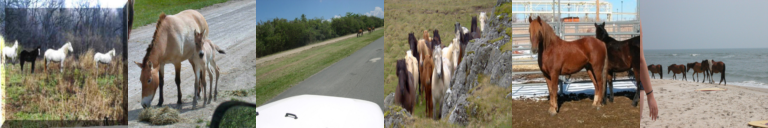

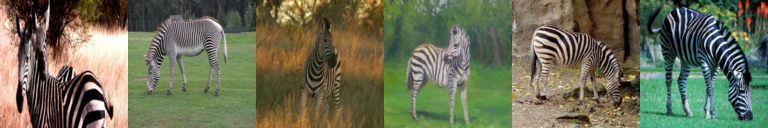

In [6]:
miniAB = minibatchAB(train_A, train_B, 6)
epoch, A, B = next(miniAB)
print(A.shape)
showX(A)
showX(B)
del miniAB, A, B

In [7]:
conv_init = tf.initializers.random_normal(0, 0.02)
gamma_init = tf.initializers.random_normal(1, 0.02)
def LeakyRelu(x, leak=0.2):
    return tf.maximum(x, x*leak)

def batchNorm(x):
    return tf.layers.batch_normalization(x, momentum=0.9, epsilon=1.01e-5, gamma_initializer=gamma_init)

def zeroPadding(x):
    return tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]])

def cropping(x):
    _, h, w, c = x.shape
    return x[:, 1:h-1, 1:w-1, :]

In [8]:
def discriminator(input_x, name='discriminator', max_layers=3):
    print(input_x)
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        _ = tf.layers.conv2d(input_x, ndf, kernel_size=4, strides=2, padding='same')
        _ = LeakyRelu(_)
        for i in range(1, max_layers):
            c = ndf * min(2**i, 2**max_layers)
            _ = tf.layers.conv2d(_, c, kernel_size=4, strides=2, padding='same', use_bias=False)
            _ = batchNorm(_)
            _ = LeakyRelu(_)
            
        c = ndf * min(2**max_layers, 8)
        _ = zeroPadding(_)
        _ = tf.layers.conv2d(_, c, kernel_size=4, use_bias=False)
        _ = batchNorm(_)
        _ = LeakyRelu(_)
        
        _ = zeroPadding(_)
        _ = tf.layers.conv2d(_, 1, kernel_size=4)
        return _

In [9]:
def UNET_G(input_x, name='generator'):
    max_ngf = ngf * 8
    def block(x, size, out_nf, use_batchnorm=True, next_nf=None):
        assert size >= 2 and size%2 == 0
        if next_nf is None:
            next_nf = min(out_nf*2, max_ngf)
        x = tf.layers.conv2d(x, next_nf, kernel_size=4, strides=2, padding='same', use_bias=(not (use_batchnorm and size > 2)))
        if size > 2:
            if use_batchnorm:
                x = batchNorm(x)
            x2 = LeakyRelu(x)
            x2 = block(x2, size//2, next_nf)
            x = tf.concat([x, x2], axis=-1)
        x = tf.nn.relu(x)
        x = tf.layers.conv2d_transpose(x, out_nf, kernel_size=4, strides=2, use_bias=(not use_batchnorm),
                                      kernel_initializer=conv_init)
        x = cropping(x)
        if use_batchnorm:
            x = batchNorm(x)
        if size <= 8:
            x = tf.layers.dropout(x, rate=0.5, training=True)
        return x
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        _ = block(input_x, imageSize, 3, False, ngf)
        _ = tf.nn.tanh(_)
        return _

In [10]:
def model_DA(input_x):
    return discriminator(input_x, 'D_A')
def model_DB(input_x):
    return discriminator(input_x, 'D_B')

def model_GA(input_x):
    return UNET_G(input_x, 'G_A')
def model_GB(input_x):
    return UNET_G(input_x, 'G_B')

In [11]:
input_a = tf.placeholder(dtype=tf.float32, shape=[None, imageSize, imageSize, 3])
input_b = tf.placeholder(dtype=tf.float32, shape=[None, imageSize, imageSize, 3])
loss_fn = lambda output, target : tf.reduce_mean(tf.abs(tf.square(output - target)))

def loss(real, fake, rec, D):
    D_real = D(real)
    D_fake = D(fake)
    loss_D_real = loss_fn(D_real, tf.ones_like(D_real))
    loss_D_fake = loss_fn(D_fake, tf.zeros_like(D_fake))
    loss_D = loss_D_real + loss_D_fake
    loss_G = loss_fn(D_fake, tf.ones_like(D_fake))
    loss_cycle = tf.reduce_mean(tf.abs(rec - real))
    return loss_D, loss_G, loss_cycle

def cycle_generator(real_input, G1, G2):
    fake_input = G1(real_input)
    rec_input = G2(fake_input)
    return real_input, fake_input, rec_input

realA, fakeB, recA = cycle_generator(input_a, model_GA, model_GB)
realB, fakeA, recB = cycle_generator(input_b, model_GB, model_GA)
loss_DA, loss_GA, loss_cycleA = loss(realA, fakeA, recA, model_DA)
loss_DB, loss_GB, loss_cycleB = loss(realB, fakeB, recB, model_DB)

loss_cycle = loss_cycleA + loss_cycleB
loss_D = loss_DA + loss_DB
loss_G = loss_GA + loss_GB + 10*loss_cycle

vars_list = tf.trainable_variables()
D_vars = [var for var in vars_list if var.name.startswith('D_A') or var.name.startswith('D_B')]
G_vars = [var for var in vars_list if var.name.startswith('G_A') or var.name.startswith('G_B')]
print('vars length = {}, D_vars length = {}, G_vars length = {}'.format(len(vars_list), len(D_vars), len(G_vars)))

D_optimizer = tf.train.AdamOptimizer(learning_rate=lrD, beta1=0.5).minimize(loss_D, var_list=D_vars)
G_optimizer = tf.train.AdamOptimizer(learning_rate=lrG, beta1=0.5).minimize(loss_G, var_list=G_vars)

sess.run(tf.global_variables_initializer())

Tensor("Placeholder:0", shape=(?, 128, 128, 3), dtype=float32)
Tensor("G_B_1/Tanh:0", shape=(?, 128, 128, 3), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 128, 128, 3), dtype=float32)
Tensor("G_A/Tanh:0", shape=(?, 128, 128, 3), dtype=float32)
vars length = 104, D_vars length = 26, G_vars length = 78


[1]/[50], [1500], errD: 0.344692587852478, 0.34627199172973633, errG 0.4074147939682007, 0.4177301228046417, errCycle=0.15452861785888672


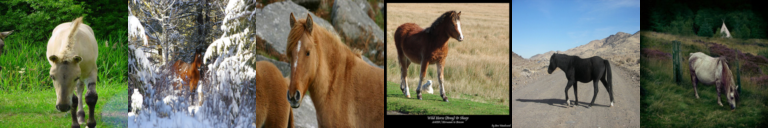

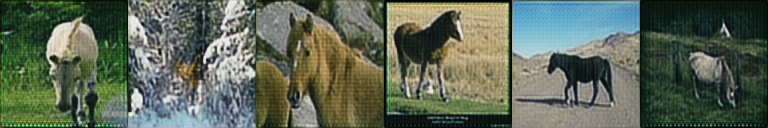

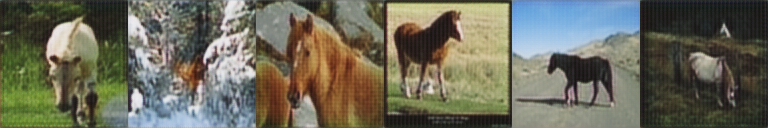

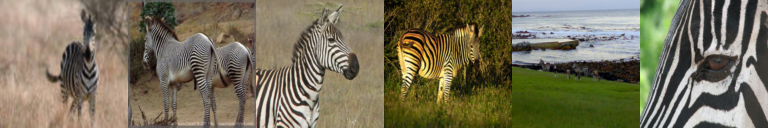

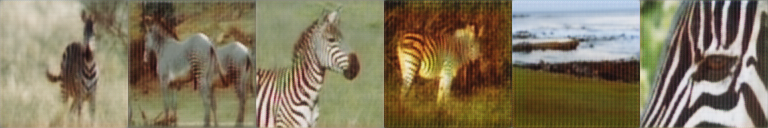

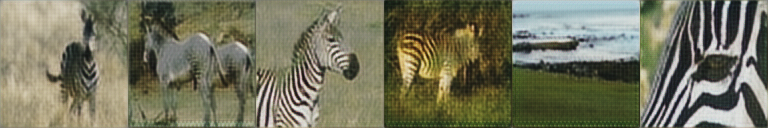

In [ ]:
from IPython.display import clear_output
epoch_num = 50
gen_iter = 0
epoch = 0
trainBatch = minibatchAB(train_A, train_B, batchSize)
testBatch = minibatchAB(test_A, test_B, 6)
while epoch <= epoch_num:
    epoch, A, B = next(trainBatch)
    _, errDA, errDB = sess.run([D_optimizer, loss_DA, loss_DB], feed_dict={input_a: A, input_b: B})
    _, errGA, errGB, errCycle = sess.run([G_optimizer, loss_GA, loss_GB, loss_cycle], feed_dict={input_a: A, input_b: B})
    gen_iter += 1
    if gen_iter % 500 == 0:
        if gen_iter % 500*2 == 0:
            clear_output()
        print('[{}]/[{}], [{}], errD: {}, {}, errG {}, {}, errCycle={}'.format(epoch, epoch_num, gen_iter, errDA, errDB, errGA, errGB, errCycle))
        _, testA, testB = next(testBatch)
        test_fakeB, test_recA, test_fakeA, test_recB = sess.run([fakeB, recA, fakeA, recB],
                                                                feed_dict={input_a: testA, input_b: testB})
        showX(testA)
        showX(test_fakeB)
        showX(test_recA)
        showX(testB)
        showX(test_fakeA)
        showX(test_recB)

In [ ]:
_, trainA, trainB = next(trainBatch)
train_fakeB, train_recA, train_fakeA, train_recB = sess.run([fakeB, recA, fakeA, recB],
                                                        feed_dict={input_a: trainA, input_b: trainB})
showX(trainA)
showX(train_fakeB)
showX(train_recA)
showX(trainB)
showX(train_fakeA)
showX(train_recB)